In [109]:
%matplotlib notebook
import math as m
import numpy as np
import scipy.constants as constants
import scipy.interpolate as inter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from jplephem.spk import SPK
from astropy.time import Time, TimeDelta
kernel = SPK.open('C:/Users/Nathan/Documents/Pyzo_Workspace/de430.bsp') # A adapter à son ordinateur

In [110]:
class Satellite:
    def __init__(self, epsilon, rayon, masse):
        self.epsilon = epsilon # Reflectivitée
        self.rayon = rayon
        self.masse = masse

# 1/ Définition des forces exercées
## a) Définition générique d'une force

In [111]:
class Force():
    def __init__(self):
        self.xpp = " A déterminer"
        self.ypp = " A déterminer"
        self.zpp = " A déterminer"
    
    def calculate(self, V, t):
        return("Error : définir calulate pour cette force")

## b) Définition précise des forces gravitationelles

Le modèle utilisé est celui de Newton $ \vec{F} = \frac{G M}{ r^{2}} \frac{\vec{r}}{r} $.

On regardera plus tard la différence avec la force dériveant du potentiel de Yukawa

In [112]:
class Gravitational_Force(Force):
    def __init__(self, n_body):
        self.mu = [2.2032 * 10**(13), 3.24859 * 10**(14), 3.986004418 * 10**(14), 4.282837 * 10**(13), 1.26686534 * 10**(17), 3.7931187 * 10**(16), 5.793939 * 10**(15), 6.836529 * 10**(15), 8.71 * 10**(11), 1.32712440018 * 10**(20)] # m^3 / s^2
        self.n_body = n_body
        
    def calculate(self, V, t):
        t_day = t / 86400 # day
        x, y, z, xp, yp , zp = V
        position_attractor = kernel[0, self.n_body].compute(t_day)
        x_attractor, y_attractor, z_attractor = position_attractor * 1000 # m
        
        d_attractor = m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2 + (z - z_attractor)**2)
        
        self.xpp = - self.mu[self.n_body - 1] * (x - x_attractor) / d_attractor**3
        self.ypp = - self.mu[self.n_body - 1] * (y - y_attractor) / d_attractor**3
        self.zpp = - self.mu[self.n_body - 1] * (z - z_attractor) / d_attractor**3
        return(None)

## c) Définition précise de la pression de radiation solaire

Le modèle utilisée est celui de [2] (cannonball model) appliqué à une sphère $\vec{F} = \pi R^{2} (1 + \epsilon) \times \frac{L_{\odot}}{4 \pi r^{2}} \times \frac{1}{c} \times \frac{\vec{r}}{r}$ où $R$ est le rayon de la sphère et $\epsilon$ sa reflexivité.

In [117]:
class Force_Radiation(Force):

    def __init__ (self, satellite):
        self.L = 1367 * 4 * m.pi * constants.astronomical_unit**2 # W
        self.sat = satellite

    def calculate(self,V,t):
        t_day = t / 86400 # day
        
        x, y, z, xp, yp, zp = V
        
        position_sun = kernel[0, 9].compute(t_day)
        x_sun, y_sun, z_sun = position_sun * 1000 # m
        
        d_sun = m.sqrt((x - x_sun)**2 + (y - y_sun)**2 + (z - z_sun)**2)
        
        flux = self.L / (4 * m.pi * d_sun**2) # W.m^-2
        P = flux / constants.c
        F = m.pi * self.sat.rayon**2 * (1 + self.sat.epsilon) * P
        
        if (x - x_sun) > 0 :
            theta = m.atan((y - y_sun) / (x - x_sun))
        elif (x - x_sun) < 0 :
            theta = m.atan((y - y_sun) / (x - x_sun)) + m.pi
        elif (y - y_sun) >= 0 :
            theta = m.pi / 2
        else :
            theta = - m.pi /2
        phi = m.atan((z - z_sun)/(m.sqrt((x - x_sun)**2 + (y - y_sun)**2)))
        
        self.zpp = F * m.sin(phi) / self.sat.masse
        self.ypp = F * m.sin(theta) * m.cos(phi) / self.sat.masse
        self.xpp = F * m.cos(theta) * m.cos(phi) / self.sat.masse
        return (None)

## d) Définition précise de la force exercée par le vent solaire

Le modèle utilisé est analogue à celui de la pression de radiation, mais on se place dans un pire cas avec $\epsilon = 1$, et le flux est calculé à partir de l'énergie cinétique des protons émis par le soleil.
On a donc $\vec{F} = 2 \pi R^{2} \times m_{p} v_{ejection} \times \frac{n_{\odot}}{4 \pi r^{2}} \times \frac{\vec{r}}{r}$. 

La vitesse d'éjection $v_{ejection}$ des vents solaires par le soleil est comprise entre 100 et 2500 $km / s$ d'après [3].

In [121]:
class Force_Vent(Force):

    def __init__(self, vitesse, satellite):
        self.n0 = 1.3 * 10**36   ## particules ejectees par seconde
        self.mp = 1.672 * 10**(-27)   ## masse du proton (ejection de plasma de H+)
        self.v = vitesse ## vitesse du plasma ejecte
        self.sat = satellite

    def calculate(self,V,t):
        t_day = t / 86400 # day
        
        x, y, z, xp, yp, zp = V
        
        position_sun = kernel[0, 9].compute(t_day)
        x_sun, y_sun, z_sun = position_sun * 1000 # m
        
        d_sun = m.sqrt((x - x_sun)**2 + (y - y_sun)**2 + (z - z_sun)**2)
        flux = self.mp * self.v * self.n0 / (4 * m.pi * d_sun**2)
        F = 2 * m.pi * self.sat.rayon**2 * flux
        
        if (x - x_sun) > 0 :
            theta = m.atan((y - y_sun) /(x - x_sun))
        elif x < 0 :
            theta = m.atan((y - y_sun) / (x - x_sun)) + m.pi
        elif (y - y_sun) >= 0 :
            theta = m.pi / 2
        else :
            theta = - m.pi /2
        phi = m.atan((z - z_sun) / (m.sqrt((x - x_sun)**2 + (y - y_sun)**2)))
        
        self.zpp = F * m.sin(phi) / self.sat.masse
        self.ypp = F * m.sin(theta) * m.cos(phi) / self.sat.masse
        self.xpp = F * m.cos(theta) * m.cos(phi) / self.sat.masse
        return (None)

# II/ Propagateur d'orbite

In [118]:
def propagateur(V, t, Forces, useless_arg):
    x, y, z, xp, yp, zp = V
    xpp = 0
    ypp = 0
    zpp = 0
    for f in Forces:
        f.calculate(V, t)
        xpp += f.xpp
        ypp += f.ypp
        zpp += f.zpp
    return [xp, yp, zp, xpp, ypp, zpp]

# III/ Tests

## a) Test de propagation keplerienne

<IPython.core.display.Javascript object>


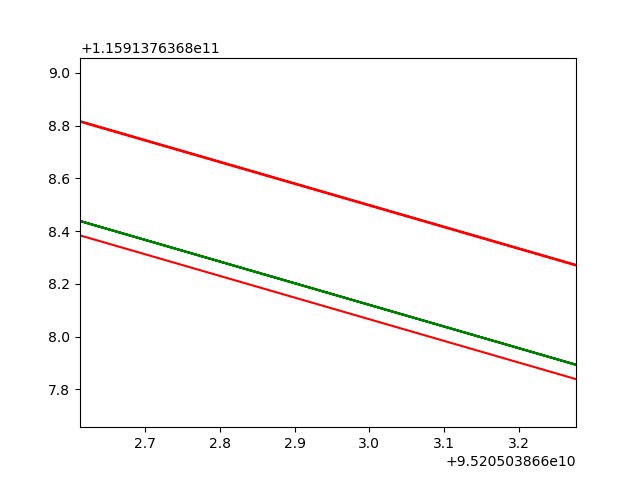

In [116]:
# paramètres de simulation
mu = 1.32712440018 * 10**(20)
a = 1.5 * 10**11
e = 0
p = a * (1 - e**2)
n = p / (1 + e)
b = a * m.sqrt(1 - e**2)
duration = 3 * m.sqrt((2 * m.pi)**2 * a**3 / mu)
k = 6 # ordre de précision

# définition des forces
'''on redéfinit localement une classe de force gravitationelle avec un attracteur fixe''' 
class Gravitational_Force_Test_1(Force):
    def __init__(self):
        self.mu = mu
        return
        
    def calculate(self, V, t):
        t_day = t / 86400 # day
        x, y, z, xp, yp , zp = V
        position_attractor = (0, 0, 0)
        x_attractor, y_attractor, z_attractor = position_attractor
        
        d_attractor = m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2 + (z - z_attractor)**2)
        
        self.xpp = - self.mu * (x - x_attractor) / d_attractor**3
        self.ypp = - self.mu * (y - y_attractor) / d_attractor**3
        self.zpp = - self.mu * (z - z_attractor) / d_attractor**3
        return(None)
force = Gravitational_Force_Test_1()
Forces = [force]

# conditions initiales
x0, y0, z0, xp0, yp0, zp0 = n, 0, 0, 0, m.sqrt(mu / p) * (1 + e), 0
V0 = [x0, y0, z0, xp0, yp0, zp0]

# propagation d'orbite
t = np.linspace(0, duration, num = 10**k)
solution = integrate.odeint(propagateur, V0, t, args = (Forces, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X, Y, Z = solution[:, 0], solution[:, 1], solution[:, 2]

# calcul de nu(t)
T = []
Nu = np.linspace(0, 2 * m.pi, 10**k)
for nu in Nu:
    E = 2 * m.atan(m.sqrt(1 - e) * m.tan(nu / 2) / m.sqrt(1 + e))
    M = E - e * m.sin(E)
    if M < 0:
        M += 2 * m.pi
    T.append(M * m.sqrt(a**3 / mu))
nu_de_t = inter.interp1d(T, Nu, bounds_error = False, fill_value = 'extrapolate')

# calcul de l'orbite théorique
X_theorique = []
Y_theorique = []
for i in range(len(t)):
    time = t[i]
    nu = nu_de_t(time)
    r = a * (1 - e**2) / (1 + e * m.cos(nu))
    X_theorique.append(r * m.cos(nu))
    Y_theorique.append(r * m.sin(nu))

# dessin
plt.plot(X, Y, 'r')
plt.plot(X_theorique, Y_theorique, 'g')
plt.show()

$Conclusion :$ On observe après 3 ans d'évolution une différence de $70m$ entre la courbe théorique et la courbe numérique. On peut augmenter cette précision en échange d'un temps de calcul augmenté.

## b) Test de propagation par pression de radiation

<IPython.core.display.Javascript object>


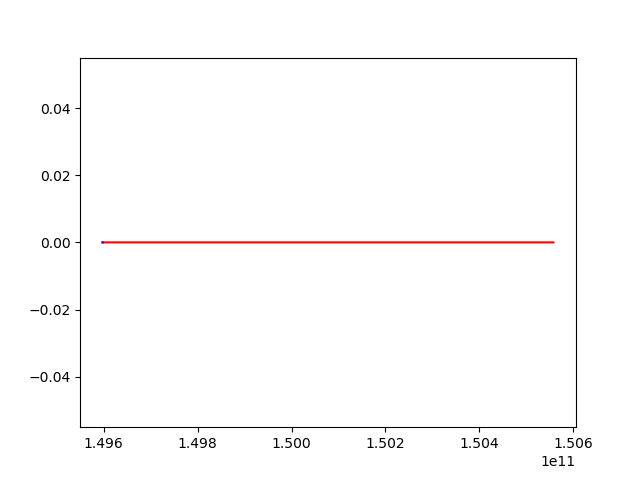

In [123]:
# Conditions initiales
x0, y0, z0, xp0, yp0, zp0 = constants.astronomical_unit, 0, 0, 0, 0, 0
V0 = [x0, y0, z0, xp0, yp0, zp0]
duration = 3 * 86400 * 365
k = 6 # ordre de précision

# Définition des forces
'''on redéfinit localement une classe de force gravitationelle avec un attracteur fixe'''
class Force_Radiation_Test(Force):

    def __init__ (self, satellite):
        self.L = 1367 * 4 * m.pi * constants.astronomical_unit**2 # W
        self.sat = satellite

    def calculate(self,V,t):
        x, y, z, xp, yp, zp = V
        r = m.sqrt(x**2 + y**2 + z**2)
        
        flux = self.L / (4 * m.pi * r**2) # W.m^-2
        P = flux / constants.c
        F = m.pi * self.sat.rayon**2 * (1 + self.sat.epsilon) * P
        
        if x > 0 :
            theta = m.atan(y / x)
        elif x < 0 :
            theta = m.atan(y / x) + m.pi
        elif y >= 0 :
            theta = m.pi / 2
        else :
            theta = - m.pi /2
        phi = m.atan(z/(m.sqrt(x**2 + y**2)))
        
        self.zpp = F * m.sin(phi) / self.sat.masse
        self.ypp = F * m.sin(theta) * m.cos(phi) / self.sat.masse
        self.xpp = F * m.cos(theta) * m.cos(phi) / self.sat.masse
        return (None)
satellite = Satellite(0.5, 1, 100)
Forces = [Force_Radiation_Test(satellite)]

# Propagation d'orbite
t = np.linspace(0, duration, num = 10**k)
solution = integrate.odeint(propagateur, V0, t, args = (Forces, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X, Y, Z = solution[:, 0], solution[:, 1], solution[:, 2]

# Dessin
plt.plot(X, Y, 'r')
plt.show()

$Conclusion :$ On obtient un déplacement purement selon x, ce qui est qualitativement attendu. On a eu un déplacement de $9.59593870 ~ 10^{8} m$. C'est l'ordre de grandeur attendu par la formule.

## c) Test de propagation par vent solaire

<IPython.core.display.Javascript object>


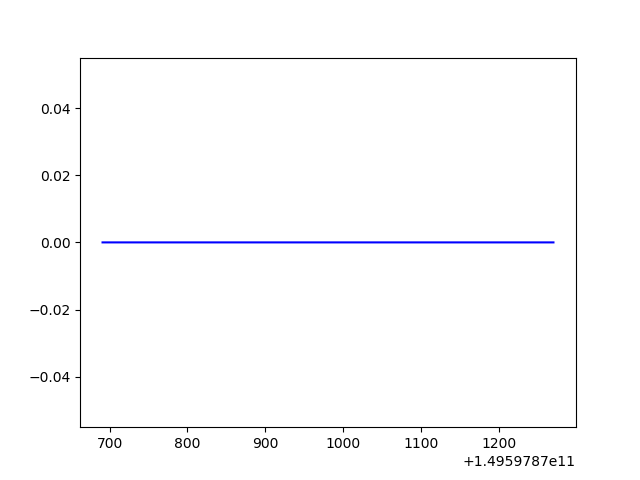

In [126]:
# Conditions initiales
x0, y0, z0, xp0, yp0, zp0 = constants.astronomical_unit, 0, 0, 0, 0, 0
V0 = [x0, y0, z0, xp0, yp0, zp0]
duration = 365 * 86400
k = 6 # ordre de précision

# Définition des forces
'''on redéfinit localement une classe de force gravitationelle avec un attracteur fixe'''
class Force_Vent_Test(Force):

    def __init__(self, vitesse, satellite):
        self.n0 = 1.3 * 10**36   ## particules ejectees par seconde
        self.mp = 1.672 * 10**(-27)   ## masse du proton (ejection de plasma de H+)
        self.v = vitesse ## vitesse du plasma ejecte
        self.sat = satellite

    def calculate(self,V,t):
        x, y, z, xp, yp, zp = V
        r = m.sqrt(x**2 + y**2 + z**2)
        flux = self.mp * self.v * self.n0 / (4 * m.pi * r**2)
        F = 2 * m.pi * self.sat.rayon**2 * flux
        
        if x > 0 :
            theta = m.atan(y/x)
        elif x < 0 :
            theta = m.atan(y / x) + m.pi
        elif y >= 0 :
            theta = m.pi / 2
        else :
            theta = - m.pi /2
        phi = m.atan(z/(m.sqrt(x**2 + y**2)))
        
        self.zpp = F * m.sin(phi) / self.sat.masse
        self.ypp = F * m.sin(theta) * m.cos(phi) / self.sat.masse
        self.xpp = F * m.cos(theta) * m.cos(phi) / self.sat.masse
        return (None)
satellite = Satellite(0.5, 1, 100)
vitesse = 2500
Forces = [Force_Vent_Test(vitesse, satellite)]

# Propagation d'orbite
t = np.linspace(0, duration, num = 10**k)
solution = integrate.odeint(propagateur, V0, t, args = (Forces, 2), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X, Y, Z = solution[:, 0], solution[:, 1], solution[:, 2]

# Dessin
plt.plot(X, Y, 'b')
plt.show()

$Conclusion :$ On obtient un déplacement purement selon x, ce qui était qualitativement attendu. On a un déplacement de $5.78 ~ 10^{2} m$ ce qui est très peu par rapport à la valeur attendue.

## d) Test des niveaux de forces

In [ ]:
# Définition des forces
'''on redéfinit localement une classe de force gravitationelle avec un attracteur au niveau de la Terre''' 
class Gravitational_Force_Test_2(Force):
    def __init__(self, n_body):
        self.mu = [2.2032 * 10**(13), 3.24859 * 10**(14), 3.986004418 * 10**(14), 4.282837 * 10**(13), 1.26686534 * 10**(17), 3.7931187 * 10**(16), 5.793939 * 10**(15), 6.836529 * 10**(15), 8.71 * 10**(11), 1.32712440018 * 10**(20)] # m^3 / s^2
        self.n_body = n_body
        
    def calculate(self, V, t):
        t_day = t / 86400 # day
        x, y, z, xp, yp , zp = V
        position_attractor = kernel[0, self.n_body].compute(t_day)
        position_attractor -= kernel[0, 3].compute(t_day)
        position_attractor -= kernel[3, 399].compute(t_day)
        x_attractor, y_attractor, z_attractor = position_attractor * 1000 # m
        
        d_attractor = m.sqrt((x - x_attractor)**2 + (y - y_attractor)**2 + (z - z_attractor)**2)
        
        self.xpp = - self.mu[self.n_body - 1] * (x - x_attractor) / d_attractor**3
        self.ypp = - self.mu[self.n_body - 1] * (y - y_attractor) / d_attractor**3
        self.zpp = - self.mu[self.n_body - 1] * (z - z_attractor) / d_attractor**3
        return(None)
force_earth = Gravitational_Force_Test_2(3)
force_sun = Gravitational_Force_Test_2(10)
Forces = [force_earth, force_sun]

# Définition des temps
time_isot = "2050-01-01T00:00:00"
Times_isot = [time_isot]
T = Time(Times_isot, format = 'isot', scale = 'utc')
Times_jd = T.jd
t = Times_jd[0] * 86400

# Position de référence dans le référentiel de la Terre (399)
x0, y0, z0, xp0, yp0, zp0 = 0, 0, 0, 0, 0, 0
V0 = [x0, y0, z0, xp0, yp0, zp0]

# Calcul des forces
H = []
Earth = []
Sun = []
for h in range(6400, 100000, 100):
    x, y, z, vx, vy, vz = V0
    x += 1000 * h
    V = [x, y, z, vx, vy, vz]
    
    Forces[0].calculate(V, t)
    xpp, ypp, zpp = Forces[0].xpp, Forces[0].ypp, Forces[0].zpp 
    a_earth = m.sqrt(xpp**2 + ypp**2 + zpp**2)
    Forces[1].calculate(V, t)
    xpp, ypp, zpp = Forces[1].xpp, Forces[1].ypp, Forces[1].zpp
    a_sun = m.sqrt(xpp**2 + ypp**2 + zpp**2)
    
    H.append(h)
    Earth.append(m.log10(a_earth))
    Sun.append(m.log10(a_sun))

# Dessin
plt.plot(H, Earth, 'b')
plt.plot(H, Sun, 'r')
plt.show()

# IV/ Calculs

## a) Influences des planètes

In [ ]:
# définition des temps
time_isot_start = "2050-01-01T00:00:00"
time_isot_end = "2053-01-01T00:00:00"
Times_isot = [time_isot_start, time_isot_end]
T = Time(Times_isot, format = 'isot', scale = 'utc')
Times_jd = T.jd
time_jd_start, time_jd_end = Times_jd
time_jd_start *= 86400
time_jd_end *= 86400
n_points = 10**6

# conditions initiales
position0, velocity0 = kernel[0, 9].compute_and_differentiate(time_jd_start / 86400)
x0, y0, z0 = position0 * 1000 # m
x0 += 10**(11) # on s'éloigne de Pluton d'une unité astronomique
xp0, yp0, zp0 = velocity0 * 1000 / 86400 # m / s
V0 = [x0, y0, z0, xp0, yp0, zp0]

# définition des forces avec tous les corps
Forces_avec = []
for n_body in range(1,11):
    if (n_body != 3):
        force = Gravitational_Force(n_body)
        Forces_avec.append(force)
# définition des forces avec juste le soleil
Forces_sans = []
for n_body in range(1,11):
    if (n_body == 10):
        force = Gravitational_Force(n_body)
        Forces_sans.append(force)

# propagation d'orbite
t = np.linspace(time_jd_start, time_jd_end, n_points)

solution = integrate.odeint(propagateur, V0, t, args = (Forces_avec), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X_avec, Y_avec, Z_avec = solution[:, 0], solution[:, 1], solution[:, 2]
plt.plot(X_avec, Y_avec, 'g')

solution = integrate.odeint(propagateur, V0, t, args = (Forces_sans), printmessg = True, rtol = 10**(-11), hmax = 1, h0 = 1)
X_sans, Y_sans, Z_sans = solution[:, 0], solution[:, 1], solution[:, 2]
plt.plot(X_sans, Y_sans, 'r')

# dessin
plt.show()
print(m.sqrt((X_avec[-1] - X_sans[-1])**2 + (Y_avec[-1] - Y_sans[-1])**2 + (Z_avec[-1] - Z_sans[-1])**2)

# Sources

[1] Satellite Orbits, O. Montenbruck & E. Gill.

[2] Using Spherical Harmonics To Model Solar Radiation Pressure Acceleration, A. Farrès & D. Folta & C. Webster.

[3] ???